# HMM: Decoding encrypted text

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
import time
import hmm

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:0.4f}'.format)

Let's use simple shift cypher

In [3]:
def encode(text, shift=1):
  alphabet = ['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
  encoded = ''
  l = len(alphabet)
  for s in text:
    encoded += alphabet[(alphabet.index(s) + shift) % l]
  return encoded

Load text to encode, analyze it a bit and encode using the defined cypher

In [4]:
text = hmm.read_text('texts/M_Vovchok/karmeluk.txt', keep_spaces=False)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

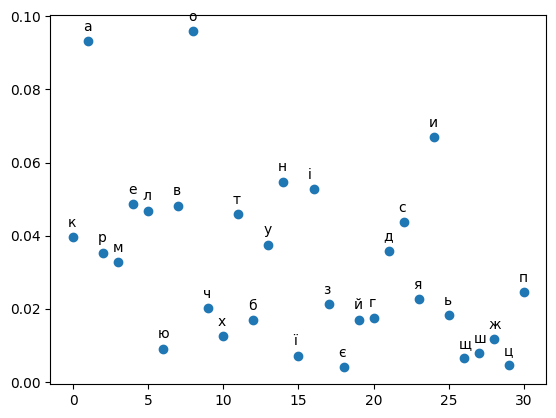

In [5]:
frequencies = hmm.get_frequencies(text)
hmm.scatter_frequencies(frequencies)

In [6]:
encoded = encode(text, shift=1)
print(encoded[:15], '...')

лбснємялгпгшплн ...


## Decoding the text

Use a HMM $\lambda = (\mu, A, B)$ where:
- $T = 50000$ number of observations
- $\{ (X_n)_{n \geq 0} \}$ hidden Markov chain with $N = 33$ states, matrix $A$ built with a text similar to the encoded one and matrix $\mu$ as a solution to the equation $\mu A = \mu$

In [25]:
clear_text = hmm.read_text('texts/M_Vovchok/karmeluk.txt', keep_spaces=False)
alphabet = ['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
alphabet_size = len(alphabet)
A_approx = np.zeros((alphabet_size, alphabet_size), dtype=float)

for t in range(len(clear_text)-1):
  i = alphabet.index(clear_text[t])
  j = alphabet.index(clear_text[t+1])
  A_approx[i][j] = A_approx[i][j] + 1
  
A_approx = A_approx + 5
A_approx = A_approx / A_approx.sum(axis=1).reshape((alphabet_size, 1))
print(pd.DataFrame(A_approx))

       0      1      2      3      4      5      6      7      8      9   \
0  0.0057 0.0190 0.0786 0.0193 0.0013 0.0458 0.0013 0.0211 0.0167 0.0419   
1  0.1202 0.0096 0.0096 0.0060 0.0060 0.0060 0.0853 0.0072 0.0072 0.0084   
2  0.1150 0.0159 0.0193 0.0145 0.0024 0.0251 0.0662 0.0024 0.0280 0.0135   
3  0.1382 0.0070 0.0105 0.0058 0.0058 0.0093 0.0186 0.0058 0.0058 0.0070   
4  0.0303 0.0303 0.0303 0.0303 0.0303 0.0303 0.0303 0.0303 0.0303 0.0303   
5  0.1271 0.0076 0.0228 0.0038 0.0032 0.0082 0.0828 0.0032 0.0126 0.0088   
6  0.0058 0.0499 0.0642 0.0153 0.0024 0.0412 0.0024 0.0067 0.0225 0.0460   
7  0.0279 0.0279 0.0619 0.0217 0.0155 0.0619 0.0155 0.0155 0.0186 0.0279   
8  0.0844 0.0175 0.0191 0.0111 0.0080 0.0366 0.2118 0.0080 0.0080 0.0143   
9  0.1889 0.0408 0.0368 0.0249 0.0050 0.0527 0.0249 0.0050 0.0119 0.0099   
10 0.0093 0.0167 0.0923 0.0157 0.0018 0.0488 0.0018 0.0021 0.0153 0.0274   
11 0.0076 0.0245 0.1019 0.0236 0.0022 0.0921 0.0022 0.0040 0.0165 0.0521   
12 0.0178 0.

In [26]:
vl, vc = np.linalg.eig(A_approx.T)
inv = vc[:, np.isclose(vl, 1)].flatten().real
inv /= inv.sum()
print("Stationary distribution:", inv)

Stationary distribution: [0.08554185 0.01852065 0.04605712 0.01916611 0.00367294 0.03521623
 0.04643526 0.00719039 0.01397959 0.02239429 0.06246084 0.05001869
 0.01001713 0.01865465 0.03848894 0.04485574 0.03250084 0.05180049
 0.08790287 0.02526563 0.03470422 0.0420283  0.0440098  0.03663937
 0.00367294 0.0146474  0.00770207 0.02148163 0.01057371 0.00934949
 0.01976749 0.01166478 0.02361854]


In [27]:
A_approx.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
hmm_decoding = hmm.BaumWelchRunner({
  "N": 33,
  "eps": 1e-2,
  "min_iterations": 200,
  "input_file": "input-decoding-2.json",
  "output_file": "bw-results/hmm-decoding-2.json",
})
# hmm_clear.load_data('texts/P_Kulish/ognennii_zmii.txt', size=10000, keep_spaces=False)
size = 3000
hmm_decoding.data = encoded[:size]
# hmm_decoding.V = list(hmm.get_frequencies(encoded).keys())
hmm_decoding.V = alphabet
hmm_decoding.generate_initial({
  "P": "normal",
  "A": "normal",
  "B": "evenly",
}, A=A_approx, P=inv)
hmm_decoding.do_not_re_estimate = ["A", "P"]
hmm_decoding.prepare_input()
hmm_decoding.run()

V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[15, 1, 21, 17, 7, 16, 32, 15, 3, 19, 3, 28, 19, 15, 17, 1]
Observation sequence length (T): 3000
Passed 200 iterations. Expected 6.586466245846624 iterations per second.
Average iterations per second: 6.656231909662817


In [60]:
len(hmm_decoding.results['evolution']['delta'])

200

/home/john/Documents/univesity_resources/markov_models/hmm/hmm.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


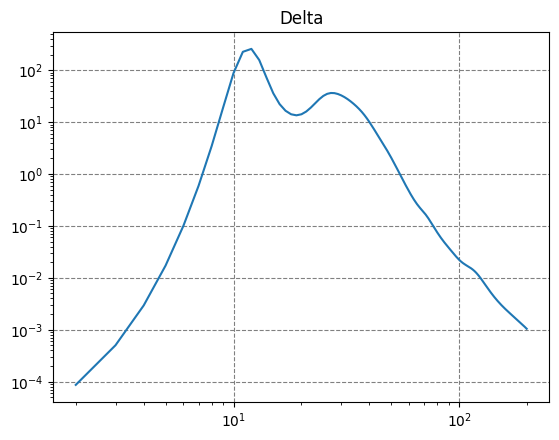

In [59]:
hmm_decoding.show_delta()

In [29]:
hmm_decoding.read_results()

{'observations': array([15,  1, 21, ...,  6,  3,  7]),
 'encoding': 'абвгґдеєжзиіїйклмнопрстуфхцчшщьюя',
 'model': {'N': 33,
  'M': 33,
  'A': array([[0.00572618, 0.01900052, 0.07860489, ..., 0.00130141, 0.02316502,
          0.01223321],
         [0.12019231, 0.00961538, 0.00961538, ..., 0.00600962, 0.00600962,
          0.00721154],
         [0.11503142, 0.01594973, 0.01933301, ..., 0.00241663, 0.00241663,
          0.00966651],
         ...,
         [0.01238739, 0.02027027, 0.03716216, ..., 0.00563063, 0.00563063,
          0.01463964],
         [0.02480916, 0.05152672, 0.04007634, ..., 0.00954198, 0.01145038,
          0.01908397],
         [0.0131951 , 0.01602262, 0.06314797, ..., 0.00471254, 0.01602262,
          0.01790763]]),
  'B':       0      1      2      3      4      5      6      7      8      9   \
  а 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
  б 0.8474 0.0000 0.0000 0.0000 0.1953 0.0000 0.0000 0.2217 0.0000 0.0000   
  в 0.0000 0.8373 0

/home/john/Documents/univesity_resources/markov_models/hmm/hmm.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


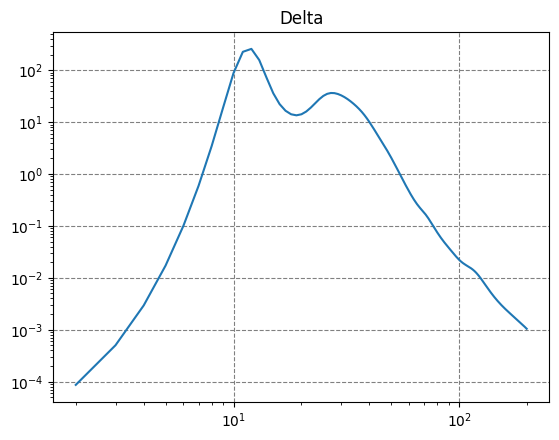

In [30]:
hmm_decoding.show_delta()

In [31]:
hmm_decoding.results['model']['B']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
а,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9602
б,0.8474,0.0000,0.0000,0.0000,0.1953,0.0000,0.0000,0.2217,0.0000,0.0000,0.0000,0.0000,0.2018,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1954,0.0000,0.0000,0.0000,0.0000,0.0000,0.1399,0.0000,0.0384
в,0.0000,0.8373,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0214,0.0000,0.0000,0.0083,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
г,0.0000,0.0000,0.8659,0.0000,0.0000,0.0000,0.0000,0.0000,0.4866,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0021,0.0000,0.0000,0.0000,0.0000,0.0000
ґ,0.0000,0.1142,0.0000,0.8152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
д,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
е,0.0000,0.0485,0.0000,0.0000,0.0000,0.7716,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2371,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
є,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0177,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ж,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7780,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
з,0.0000,0.0000,0.0000,0.0131,0.0000,0.0003,0.0000,0.0000,0.4878,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0298,0.0000,0.0000,0.0000,0.0000,0.0000


In [32]:
df = pd.DataFrame(hmm_decoding.results['model']['B'].transpose().to_numpy(), index=alphabet)
df.columns = alphabet
df

,а,б,в,г,ґ,д,е,є,ж,з,и,і,ї,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,щ,ь,ю,я
а,0.0000,0.8474,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310,0.0468,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0747,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
б,0.0000,0.0000,0.8373,0.0000,0.1142,0.0000,0.0485,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
в,0.0000,0.0000,0.0000,0.8659,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1331,0.0000,0.0000,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
г,0.0000,0.0000,0.0000,0.0000,0.8152,0.0000,0.0000,0.0000,0.0000,0.0131,0.0000,0.0000,0.0000,0.0000,0.0344,0.0000,0.1373,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ґ,0.0000,0.1953,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8046,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
д,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7716,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0548,0.0000,0.0000,0.0000,0.1694,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0039,0.0000,0.0000,0.0000
е,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
є,0.0000,0.2217,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7780,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ж,0.0000,0.0000,0.0000,0.4866,0.0000,0.0000,0.0000,0.0000,0.0000,0.4878,0.0236,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0010,0.0000,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000
з,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9846,0.0000,0.0000,0.0154,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [33]:
viterbi_decoder = hmm.ViterbiRunner({
  "data": [alphabet.index(e) for e in encoded],
  # "data": hmm_decoding.results['observations'].tolist(),
  "N": len(alphabet),
  "input_file": "viterbi-decoding-2.json",
  "output_file": "vt-results/viterbi-decoding-2.json",
  "P": hmm_decoding.results['model']['P'].tolist(),
  "A": hmm_decoding.results['model']['A'].tolist(),
  # "B": hmm_decoding.results['model']['B'].values.tolist(),
  "B": hmm_decoding.results['model']['B'].transpose().values.tolist()
})
viterbi_decoder.prepare_input()
viterbi_decoder.run()

Observation sequence length (T): 39479


In [34]:
viterbi_decoder.read_results()

{'delta': [[-2.458749535845083,
   -3.988868876851029,
   -3.077872990656482,
   -3.954611796387208,
   -5.606762028340312,
   -3.346248269010741,
   -3.069696100150574,
   -4.935006602861727,
   -4.270157050229209,
   -3.798949168095994,
   -2.773215434394356,
   -2.995358452813675,
   -4.603458689523538,
   -3.853003474921292,
   -2.26029716796929,
   -3.104303794417753,
   -3.426489192806063,
   -2.960355713783667,
   -2.431522804592597,
   -3.587437976787355,
   -3.360893848520384,
   -3.1694120911771,
   -3.123342865248254,
   -3.306632054523608,
   -5.606762028340312,
   -4.194489792714437,
   -4.866266106731315,
   -3.840556959953046,
   -4.54385661739415,
   -4.67243359491177,
   -3.923716527070921,
   -4.451180862763747,
   -3.745723467911731],
  [-5.422146132968154,
   -127.5570480303752,
   -213.9271610006553,
   -262.3044946288622,
   -7.390092854939126,
   -167.0527034141851,
   -31.25520382607314,
   -6.85219622633846,
   -123.2732861472896,
   -66.14440747148015,
   -31.

In [35]:
states = viterbi_decoder.results['q']
decoded = ''
for s in states:
  decoded += alphabet[s]

In [36]:
decoded[:200]

'кармелюквовчокмаркохтобувавнаукраїніхтознаукраїнухтобувавізнаєтойнехайзгадаєахтонебувавінезнаєтойнехайсобіуявитьщотамскрізьбіліхатиувишневихсадкахівесноювесноюламдужегарноякусісадочкизьцвітутьґусісоло'

In [37]:
guesses = [1 if text[i] == decoded[i] else 0 for i in range(len(decoded))]
print(f"Correctly decoded {sum(guesses) / len(decoded) * 100}%")

Correctly decoded 98.01160110438461%


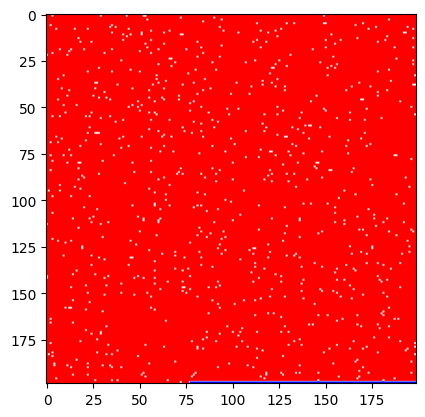

In [38]:
gar = np.array(guesses)
# gar = gar.reshape((gar.shape[0], 1))
ns = np.ceil(np.sqrt(gar.shape[0])).astype(int)
s = np.full(ns**2, -1)
s[:gar.size] = gar
s = s.reshape(ns,ns)
plt.imshow(s, cmap=cm['bwr'], vmin=-1, vmax=1)

In [48]:
def process_encode_decode(text_path, base_path, transpose=False):
  text = hmm.read_text(text_path, keep_spaces=False)
  encoded = encode(text, shift=1)
  print(encoded[:15], '...')
  
  clear_text = hmm.read_text(base_path, keep_spaces=False)
  alphabet = ['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
  alphabet_size = len(alphabet)
  A_approx = np.zeros((alphabet_size, alphabet_size), dtype=float)

  for t in range(len(clear_text)-1):
    i = alphabet.index(clear_text[t])
    j = alphabet.index(clear_text[t+1])
    A_approx[i][j] = A_approx[i][j] + 1
    
  A_approx = A_approx + 5
  A_approx = A_approx / A_approx.sum(axis=1).reshape((alphabet_size, 1))
  # print(pd.DataFrame(A_approx))
  
  vl, vc = np.linalg.eig(A_approx.T)
  inv = vc[:, np.isclose(vl, 1)].flatten().real
  inv /= inv.sum()
  print("Stationary distribution:", inv)
  
  hmm_decoding = hmm.BaumWelchRunner({
    "N": 33,
    "eps": 1e-2,
    "min_iterations": 200,
    "input_file": "input-decoding-2.json",
    "output_file": "bw-results/hmm-decoding-2.json",
  })
  size = 3000
  hmm_decoding.data = encoded[:size]
  hmm_decoding.V = alphabet
  hmm_decoding.generate_initial({
    "P": "normal",
    "A": "normal",
    "B": "evenly",
  }, A=A_approx, P=inv)
  hmm_decoding.do_not_re_estimate = ["A", "P"]
  hmm_decoding.prepare_input()
  hmm_decoding.run()
  hmm_decoding.read_results()
  
  viterbi_decoder = hmm.ViterbiRunner({
    "data": [alphabet.index(e) for e in encoded],
    "N": len(alphabet),
    "input_file": "viterbi-decoding-2.json",
    "output_file": "vt-results/viterbi-decoding-2.json",
    "P": hmm_decoding.results['model']['P'].tolist(),
    "A": hmm_decoding.results['model']['A'].tolist(),
    "B": hmm_decoding.results['model']['B'].values.tolist() if transpose else hmm_decoding.results['model']['B'].transpose().values.tolist(),
  })
  viterbi_decoder.prepare_input()
  viterbi_decoder.run()
  viterbi_decoder.read_results()
  
  states = viterbi_decoder.results['q']
  decoded = ''
  for s in states:
    decoded += alphabet[s]
    
  print('First decoded symbols:')
  print(decoded[:200])
  
  guesses = [1 if text[i] == decoded[i] else 0 for i in range(len(decoded))]
  print(f"Correctly decoded {sum(guesses) / len(decoded) * 100}%")
  
  gar = np.array(guesses)
  ns = np.ceil(np.sqrt(gar.shape[0])).astype(int)
  s = np.full(ns**2, -1)
  s[:gar.size] = gar
  s = s.reshape(ns,ns)
  plt.imshow(s, cmap=cm['bwr'], vmin=-1, vmax=1)

лбснємялгпгшплн ...
Stationary distribution: [0.09085575 0.02454393 0.04194629 0.01729756 0.00287419 0.03306243
 0.05551422 0.01086962 0.01576456 0.0210605  0.05438072 0.04384362
 0.00820469 0.01698433 0.03867081 0.03602409 0.02896833 0.05445298
 0.09016066 0.02982211 0.03313094 0.04171919 0.0529378  0.03778197
 0.00294386 0.01336075 0.00602707 0.02006715 0.00963304 0.00909291
 0.02224211 0.01147936 0.02428246]
V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[15, 1, 21, 17, 7, 16, 32, 15, 3, 19, 3, 28, 19, 15, 17, 1]
Observation sequence length (T): 3000
Passed 200 iterations. Expected 6.52211174617017 iterations per second.
Average iterations per second: 6.512795040990556
Observation sequence length (T): 39479
First decoded symbols:
тілпубсїібюабфпілїітобітюібоітєліомотобемітєлімотитібтюібовоіпобїмутібетіміпітобоубтюібомуиліпобїмутібпіботтінгогішіпффловобоботіортіналуінипімїітобупопсюупопсшіпетіутілубцфтпопімбаєовібічогозотпопібі
Correctly decoded 1.9200081055751157%


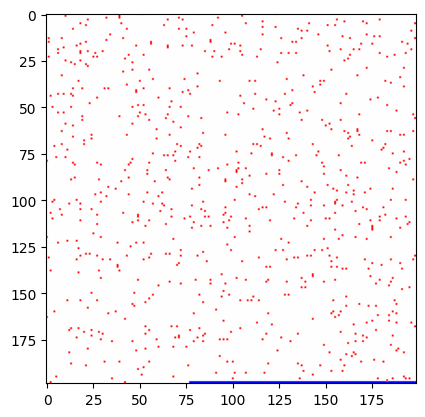

In [49]:
process_encode_decode(
  'texts/M_Vovchok/karmeluk.txt',
  'texts/M_Vovchok/instytutka.txt',
  transpose=True,
)

In [53]:
def process_encode_decode_ls(text_path, base_path, transpose=False, learning_sizes=[3000]):
  text = hmm.read_text(text_path, keep_spaces=False)
  encoded = encode(text, shift=1)
  print(encoded[:15], '...')
  
  clear_text = hmm.read_text(base_path, keep_spaces=False)
  alphabet = ['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
  alphabet_size = len(alphabet)
  A_approx = np.zeros((alphabet_size, alphabet_size), dtype=float)

  for t in range(len(clear_text)-1):
    i = alphabet.index(clear_text[t])
    j = alphabet.index(clear_text[t+1])
    A_approx[i][j] = A_approx[i][j] + 1
    
  A_approx = A_approx + 5
  A_approx = A_approx / A_approx.sum(axis=1).reshape((alphabet_size, 1))
  # print(pd.DataFrame(A_approx))
  
  vl, vc = np.linalg.eig(A_approx.T)
  inv = vc[:, np.isclose(vl, 1)].flatten().real
  inv /= inv.sum()
  # print("Stationary distribution:", inv)
  
  for ls in learning_sizes:
    hmm_decoding = hmm.BaumWelchRunner({
      "N": 33,
      "eps": 1e-2,
      "min_iterations": 200,
      "input_file": "input-decoding-2.json",
      "output_file": "bw-results/hmm-decoding-2.json",
    })
    # size = ls
    hmm_decoding.data = encoded[:ls]
    hmm_decoding.V = alphabet
    hmm_decoding.generate_initial({
      "P": "normal",
      "A": "normal",
      "B": "evenly",
    }, A=A_approx, P=inv)
    hmm_decoding.do_not_re_estimate = ["A", "P"]
    hmm_decoding.prepare_input()
    hmm_decoding.run()
    hmm_decoding.read_results()
    
    viterbi_decoder = hmm.ViterbiRunner({
      "data": [alphabet.index(e) for e in encoded],
      "N": len(alphabet),
      "input_file": "viterbi-decoding-2.json",
      "output_file": "vt-results/viterbi-decoding-2.json",
      "P": hmm_decoding.results['model']['P'].tolist(),
      "A": hmm_decoding.results['model']['A'].tolist(),
      "B": hmm_decoding.results['model']['B'].values.tolist() if transpose else hmm_decoding.results['model']['B'].transpose().values.tolist(),
    })
    viterbi_decoder.prepare_input()
    viterbi_decoder.run()
    viterbi_decoder.read_results()
    
    states = viterbi_decoder.results['q']
    decoded = ''
    for s in states:
      decoded += alphabet[s]
      
    print('First decoded symbols:')
    print(decoded[:100])
    
    guesses = [1 if text[i] == decoded[i] else 0 for i in range(len(decoded))]
    print(f"[size={ls}] Correctly decoded {sum(guesses) / len(decoded) * 100}%")

In [56]:
process_encode_decode_ls(
  'texts/M_Vovchok/karmeluk.txt',
  'texts/M_Vovchok/devyat_brativ.txt',
  transpose=False,
  learning_sizes=[1000, 2000, 3000, 5000, 8000, 10000]
)

лбснємялгпгшплн ...
V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[15, 1, 21, 17, 7, 16, 32, 15, 3, 19, 3, 28, 19, 15, 17, 1]
Observation sequence length (T): 1000
Passed 200 iterations. Expected 18.7067757557364 iterations per second.
Average iterations per second: 18.60195153142439
Observation sequence length (T): 39479
First decoded symbols:
ларгелюшвовчокварпохтобувавнаукрайнімтознаукрайнухтобувавізналбойнемайзмадаластонебувавінезналбойнем
[size=1000] Correctly decoded 88.49261632766787%
V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[15, 1, 21, 17, 7, 16, 32, 15, 3, 19, 3, 28, 19, 15, 17, 1]
Observation sequence length (T): 2000
Passed 200 iterations. Expected 9.192076829486558 iterations per second.
Average iterations per second: 8.93281583442241
Observation sequence length (T): 39479
First decoded symbols:
лармелюквовчокмаркомтобувавзаукрайнімтознаукрайнумтобувавізнаєтойнемайїгадаєамтонебувавінезнаєтойнем
[size=2000] Correctly decoded 92.07173433977557%
V: абвгґдеєжзиії

In [57]:
process_encode_decode_ls(
  'texts/M_Vovchok/devyat_brativ.txt',
  'texts/M_Vovchok/try_doli.txt',
  transpose=False,
  learning_sizes=[1000, 2000, 3000, 5000, 8000, 10000]
)

зімбтпвїфепгблп ...
V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[9, 11, 16, 1, 22, 19, 2, 12, 24, 6, 19, 3, 1, 15, 19, 16]
Observation sequence length (T): 1000
Passed 200 iterations. Expected 19.68777157572901 iterations per second.
Average iterations per second: 19.1619450737854
Observation sequence length (T): 62317
First decoded symbols:
итіновиллуденодівотрененівудібопатеніненьскудісилівощяотккитсокотяішінеченіяситівомалиумопяивитьсиви
[size=1000] Correctly decoded 0.2583564677375355%
V: абвгґдеєжзиіїйклмнопрстуфхцчшщьюя
Data[0..15]: @[9, 11, 16, 1, 22, 19, 2, 12, 24, 6, 19, 3, 1, 15, 19, 16]
Observation sequence length (T): 2000
Passed 200 iterations. Expected 9.755283832278748 iterations per second.
Average iterations per second: 9.597255764021012
Observation sequence length (T): 62317
First decoded symbols:
тиласопсудоваколокисванаподолітанемалащастядолібулогіркеїїжиттитерпілавонапревеликунуждутавбочествоч
[size=2000] Correctly decoded 89.90323667699023%
V: абвгґдеєжзиії